In [1]:
import os
import re
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def preprocess_code(code):
    code = re.sub(r'//.*|/\*[\s\S]*?\*/|#.*', '', code)  # Remove comments
    code = re.sub(r'\s+', ' ', code)  # Normalize whitespace
    return code.strip()

In [3]:
def load_code_files(folder_path):
    files = []
    contents = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".py") or filename.endswith(".cpp") or filename.endswith(".java"):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                files.append(filename)
                contents.append(preprocess_code(file.read()))
    return files, contents

In [14]:
def compute_similarity_dag(code_folder, threshold=0.6):
    files, code_snippets = load_code_files(code_folder)
    
    # Vectorize using TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(code_snippets)
    
    # Cosine similarity matrix
    similarity = cosine_similarity(tfidf_matrix)
    
    # 📊 Build DAG
    G = nx.DiGraph()
    G.add_nodes_from(files)

    cheaters = []  # Store suspicious file pairs

    for i in range(len(files)):
        for j in range(i+1, len(files)):  # Only i -> j to prevent cycles
            sim_score = similarity[i][j]
            if sim_score > threshold:
                G.add_edge(files[i], files[j], weight=sim_score)
                cheaters.append((files[i], files[j], sim_score))  # 🚨 log as "cheat"
    
    return G, similarity, files, cheaters


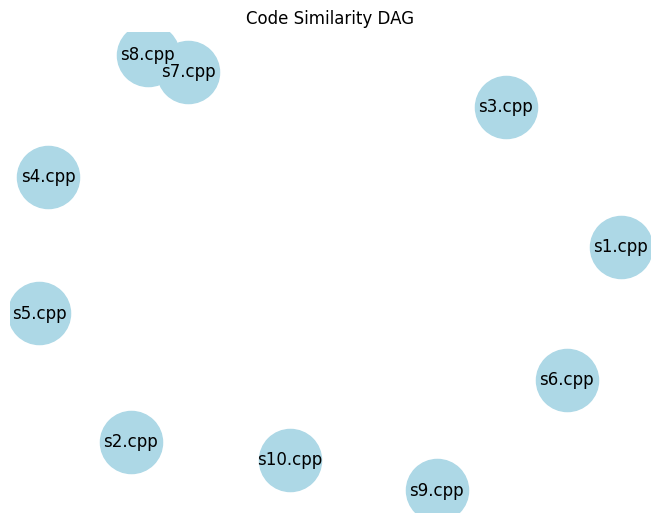

In [16]:
folder=r"kadance Algo"
dag, sim_matrix, filenames,cheaters = compute_similarity_dag(folder)

# 📈 Visualize
import matplotlib.pyplot as plt

pos = nx.spring_layout(dag)
nx.draw(dag, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000)
edge_labels = nx.get_edge_attributes(dag, 'weight')
nx.draw_networkx_edge_labels(dag, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})
plt.title("Code Similarity DAG")
plt.show()



In [17]:
if cheaters:
    print("🚨 Potential Cheating Detected:")
    for f1, f2, score in cheaters:
        print(f" - {f1} and {f2} → Similarity: {score:.2f}")
else:
    print("✅ No suspicious similarity found.")

🚨 Potential Cheating Detected:
 - s7.cpp and s8.cpp → Similarity: 1.00
